<a href="https://colab.research.google.com/github/mcontrerassc/Detectron-Clothing/blob/main/clothing_classification_with_detectron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import ast
import cv2

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

# Note: Pytorch uses a channels-first format:
# [batch_size, num_channels, height, width]

print(torch.__version__)
print(torchvision.__version__)


2.2.1+cu121
0.17.1+cu121


In [ ]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
#@title Install detectron2
%cd /content/
# install detectron2:
!git clone https://github.com/facebookresearch/detectron2
%cd /content/detectron2
!pip install -r requirements.txt
!python setup.py install
!pip install git+https://github.com/facebookresearch/fvcore.git

/content
Cloning into 'detectron2'...
remote: Enumerating objects: 15671, done.
remote: Counting objects: 100% (394/394), done.
remote: Compressing objects: 100% (292/292), done.
remote: Total 15671 (delta 174), reused 276 (delta 102), pack-reused 15277
Receiving objects: 100% (15671/15671), 6.50 MiB | 13.73 MiB/s, done.
Resolving deltas: 100% (11289/11289), done.
/content/detectron2
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************

In [ ]:
# Set the seed values

import random

seed_val = 101

os.environ['PYTHONHASHSEED'] = str(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.backends.cudnn.deterministic = True

In [ ]:
!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog

from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode

import matplotlib.pyplot as plt
import cv2
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data + Preprocessing

In [ ]:
import zipfile
import os

zip_path = '/content/drive/My Drive/img.zip'
extract_path = '/content/unzipped_images/'

# unzip the data
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Split the data into 20% for testing and 80% foro training

In [ ]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import os


data = pd.read_csv('/content/10k_int.csv')
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)



In [ ]:
train_data

image_name  category_label  x_1  \
23744  img/Classic_Distressed_Denim_Jacket/img_000000...               7   57   
22278  img/Life_in_Progress_Denim_Jacket/img_00000037...               7   58   
75511        img/Contrast_Crew_Neck_Tee/img_00000034.jpg               1    1   
64451     img/Grid_Print_Zippered_Skirt/img_00000038.jpg               5   45   
36712  img/Belted_Abstract_Print_Jumpsuit/img_0000002...               8   68   
...                                                  ...             ...  ...   
6265   img/Hidden_Zippered_Placket_Blouse/img_0000003...               2   31   
54886  img/Abstract_Print_Performance_Shorts/img_0000...               4   98   
76820    img/Sun_Graphic_Racerback_Tank/img_00000036.jpg               1   50   
860    img/Pintucked_Button-Down_Blouse/img_00000028.jpg               2  171   
15795  img/Asymmetric_Printed_Wrap_Dress/img_00000048...               0    2   

       y_1  x_2  y_2  
23744   55  143  144  
22278   62  142  176  
75511    1  228  250  
64451  148  163  268  
36712   28  153  290  
...    ...  ...  ...  
6265    77  165  278  
54886  174  207  288  
76820    9  178  264  
860     74  289  219  
15795   29  174  269  

[69568 rows x 6 columns]

In [ ]:
val_data

image_name  category_label  x_1  \
34107     img/Smocked_Wide-Leg_Jumpsuit/img_00000041.jpg               8   64   
68241               img/Cacti_Print_Tee/img_00000037.jpg               1   22   
78834  img/Classic_Mid-Rise_Skinny_Jeans/img_00000019...               3   81   
75702     img/Bandana_Print-Paneled_Tee/img_00000024.jpg               1   73   
25306       img/Modernist_Hooded_Jacket/img_00000033.jpg               7   21   
...                                                  ...             ...  ...   
53417        img/Pintucked_Woven_Shorts/img_00000008.jpg               4   25   
61891  img/Sequined_Chevron-Pattern_Skirt/img_0000002...               5   51   
14108             img/Lace_Halter_Dress/img_00000006.jpg               0    1   
66174          img/Pleated_Skater_Skirt/img_00000007.jpg               5   43   
68082              img/Iguana_Print_Tee/img_00000030.jpg               1  108   

       y_1  x_2  y_2  
34107   17  216  300  
68241   78  164  256  
78834  121  194  300  
75702   38  171  170  
25306   65  177  273  
...    ...  ...  ...  
53417  163  156  281  
61891   23  164  131  
14108   68  228  300  
66174   97  159  167  
68082   41  188  154  

[17393 rows x 6 columns]

In [ ]:
val_data.groupby(['category_label']).count()

image_name   x_1   y_1   x_2   y_2
category_label                                    
0                     1954  1954  1954  1954  1954
1                     1959  1959  1959  1959  1959
2                     1971  1971  1971  1971  1971
3                     1987  1987  1987  1987  1987
4                     2008  2008  2008  2008  2008
5                     2085  2085  2085  2085  2085
6                     2020  2020  2020  2020  2020
7                     1983  1983  1983  1983  1983
8                     1260  1260  1260  1260  1260
9                      166   166   166   166   166

In [ ]:
train_data.groupby(['category_label']).count()

image_name   x_1   y_1   x_2   y_2
category_label                                    
0                     8046  8046  8046  8046  8046
1                     8041  8041  8041  8041  8041
2                     8029  8029  8029  8029  8029
3                     8013  8013  8013  8013  8013
4                     7992  7992  7992  7992  7992
5                     7915  7915  7915  7915  7915
6                     7980  7980  7980  7980  7980
7                     8017  8017  8017  8017  8017
8                     4893  4893  4893  4893  4893
9                      642   642   642   642   642

# Register Dataset in COCO format

In [ ]:
def register(df):
    image_root = '/content/unzipped_images'

    # Convert CSV to Detectron2 format
    dataset_dicts = []
    for idx, row in df.iterrows():
        record = {}

        # Image details
        img_path = os.path.join(image_root, row['image_name'])
        # Check if the image file exists
        if not os.path.exists(img_path):
            #print(f"Warning: Image file '{img_path}' does not exist. Skipping.")
            continue
        #print(f"Warning: Image file '{img_path}' exists. NOT SKIPPING.")  # This line added
        height, width = cv2.imread(img_path).shape[:2]
        record['file_name'] = img_path
        record['height'] = height
        record['width'] = width
        record['image_id'] = img_path

        # Annotations
        objs = []
        category_id = row['category_label']
        obj = {
            'bbox': [row['x_1'], row['y_1'], row['x_2'], row['y_2']],
            'bbox_mode': 0,  # Detectron2 uses XYXY_ABS format
            'category_id': category_id,
            'iscrowd': 0
        }
        objs.append(obj)
        record['annotations'] = objs

        dataset_dicts.append(record)

    # Save as JSON

    return dataset_dicts

In [ ]:
train_dict = register(train_data)

In [ ]:
val_dict = register(val_data)

In [ ]:
classes = ["Dress", "Top", "Blouse", "Trousers", "Shorts", "Skirt", "Pullover", "Jacket", "Jumpsuit", "Coverup"]

In [ ]:
DatasetCatalog.register("train_dataset2", lambda: register(train_data))
DatasetCatalog.register("val_dataset2", lambda: register(val_data))

MetadataCatalog.get("train_dataset2").thing_classes=classes
MetadataCatalog.get("val_dataset2").thing_classes=classes

content


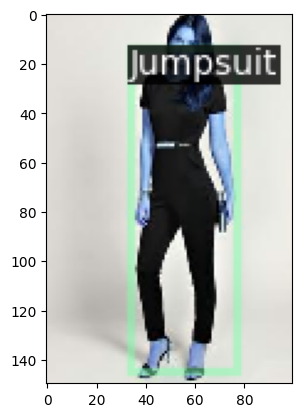

In [ ]:
# Check that the data registration process worked

train_metadata = MetadataCatalog.get("train_dataset2")

i = 4
d = train_dict[i]

fname = d['file_name'].split('/')[1]
print(fname)

image = cv2.imread(d['file_name'])

visualizer = Visualizer(image[:, :, ::-1], metadata=train_metadata, scale=0.5)
out = visualizer.draw_dataset_dict(d)
plt.imshow(out.get_image()[:, :, ::-1])

In [ ]:
# Create a config object.
cfg = get_cfg()

# Change the config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train_dataset2",)
cfg.DATASETS.TEST = ()   # Not using the validation data during training.
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 2000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10

# Uncomment this line to see all fields in the config.
# print(cfg)

In [ ]:
# Trainer
os.makedirs(cfg.OUTPUT_DIR, exist_ok = True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume = False)
trainer.train()

[05/06 21:12:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:01, 138MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[05/06 21:13:17 d2.engine.train_loop]: Starting training from iteration 0
[05/06 21:13:29 d2.utils.events]:  eta: 0:12:48  iter: 19  total_loss: 2.723  loss_cls: 2.288  loss_box_reg: 0.4926  loss_rpn_cls: 0.002778  loss_rpn_loc: 0.009419    time: 0.3802  last_time: 0.3751  data_time: 0.0136  last_data_time: 0.0052   lr: 4.9952e-05  max_mem: 3636M
[05/06 21:13:38 d2.utils.events]:  eta: 0:12:32  iter: 39  total_loss: 1.621  loss_cls: 0.9445  loss_box_reg: 0.5456  loss_rpn_cls: 0.003557  loss_rpn_loc: 0.009015    time: 0.3487  last_time: 0.2808  data_time: 0.0050  last_data_time: 0.0044   lr: 9.9902e-05  max_mem: 3784M
[05/06 21:13:45 d2.utils.events]:  eta: 0:12:23  iter: 59  total_loss: 0.9878  loss_cls: 0.4846  loss_box_reg: 0.4822  loss_rpn_cls: 0.001405  loss_rpn_loc: 0.008012    time: 0.3446  last_time: 0.4142  data_time: 0.0049  last_data_time: 0.0047   lr: 0.00014985  max_mem: 3857M
[05/06 21:13:51 d2.utils.events]:  eta: 0:12:04  iter: 79  total_loss: 0.8776  loss_cls: 0.421  lo

In [ ]:
# Change the config
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # set the testing threshold for this model
cfg.DATASETS.TEST = ("val_dataset2", )

# Create a predictor
predictor = DefaultPredictor(cfg)

[05/06 21:31:21 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [ ]:
# Get the metadata
val_metadata = MetadataCatalog.get("val_dataset2")

# Get an image to predict on.
# Change this number to select a different image from the val set.
i = 0

d = val_dict[i]
im = cv2.imread(d["file_name"])

# make a prediction
outputs = predictor(im)

outputs

{'instances': Instances(num_instances=3, image_height=300, image_width=240, fields=[pred_boxes: Boxes(tensor([[ 67.8808,  17.4906, 189.5708, 300.0000],
         [ 75.9193,  78.6330, 195.0610, 293.3966],
         [ 60.7224,  21.2540, 201.1006, 297.0740]], device='cuda:0')), scores: tensor([0.7094, 0.5286, 0.4771], device='cuda:0'), pred_classes: tensor([8, 3, 0], device='cuda:0')])}

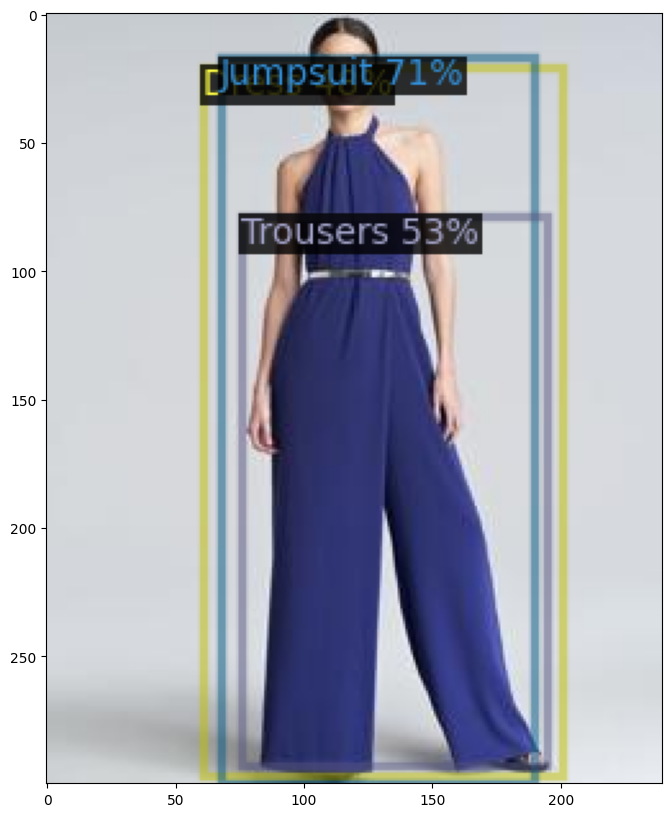

In [ ]:
# Visulaize the predicted bounding boxes

# Keep scale=1 in order to associate the predicted coords with the image below.
# If the scale is different the predicted coords won't match the bbox shown on
# the image below.
v = Visualizer(im[:, :, ::-1], metadata=val_metadata, scale=1)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))


plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
class MyTrainer(DefaultTrainer):
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
      if output_folder is None:
         output_folder = os.path.join(cfg.OUTPUT_DIR,"inference")
      return COCOEvaluator(dataset_name, cfg, True, output_folder)

[05/06 21:31:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


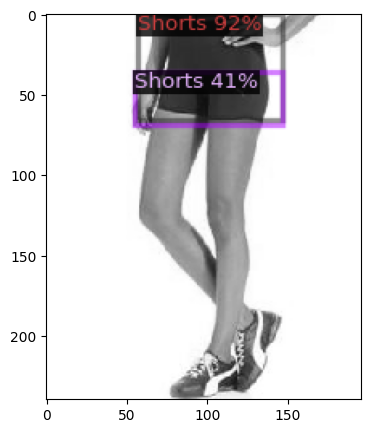

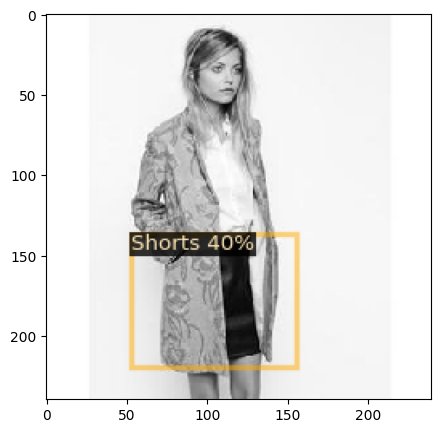

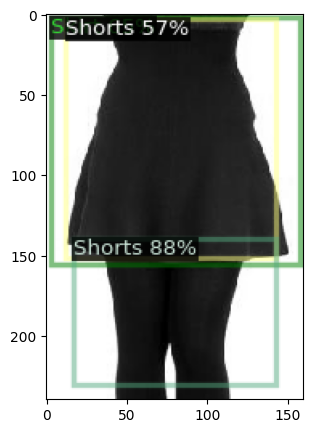

In [ ]:
from detectron2.utils.visualizer import ColorMode

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4
cfg.DATASETS.TEST = ("val_dataset2", )
predictor = DefaultPredictor(cfg)


dataset_dicts = val_dict
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (5, 5))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

# Evaluating the model

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("val_dataset2", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "val_dataset2")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[05/06 21:31:51 d2.evaluation.coco_evaluation]: Trying to convert 'val_dataset2' to COCO format ...
[05/06 21:31:51 d2.data.datasets.coco]: Converting annotations of dataset 'val_dataset2' to COCO format ...)
[05/06 21:32:07 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[05/06 21:32:10 d2.data.datasets.coco]: Conversion finished, #images: 17392, #annotations: 17392
[05/06 21:32:10 d2.data.datasets.coco]: Caching COCO format annotations at './output/val_dataset2_coco_format.json' ...
[05/06 21:32:27 d2.data.build]: Distribution of instances among all 10 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   Dress    | 1954         |    Top     | 1958         |   Blouse   | 1971         |
|  Trousers  | 1987         |   Shorts   | 2008         |   Skirt    | 2085         |
|  Pullover  | 2020         |   Jacket   | 1983         |  Jumpsu

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/output/model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[05/06 22:53:07 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...


tensor([3, 2])


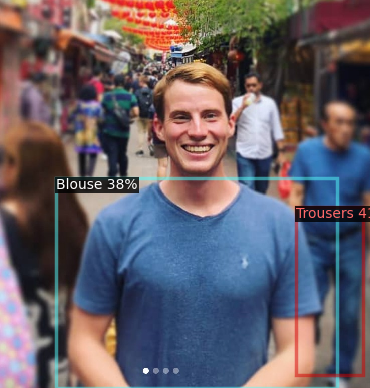

In [ ]:
img = cv2.imread("/content/drive/MyDrive/content/nicolai.jpeg")
outputs = predictor(img)

pred_classes = outputs["instances"].to("cpu").pred_classes
print (pred_classes)
# Visualize the image with predictions
visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("train_dataset2"), scale=0.5)
v = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

tensor([6, 3, 7, 4])


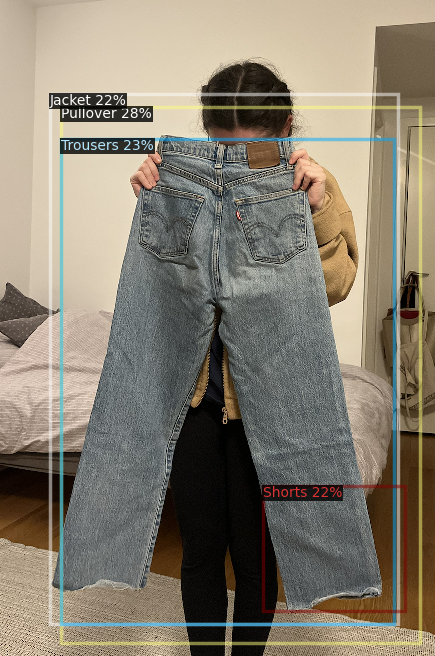

In [ ]:
img = cv2.imread("/content/drive/MyDrive/content/jeans.jpeg")
outputs = predictor(img)

pred_classes = outputs["instances"].to("cpu").pred_classes
print (pred_classes)
# Visualize the image with predictions
visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("val_dataset2"), scale=0.5)
v = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

tensor([3, 3])


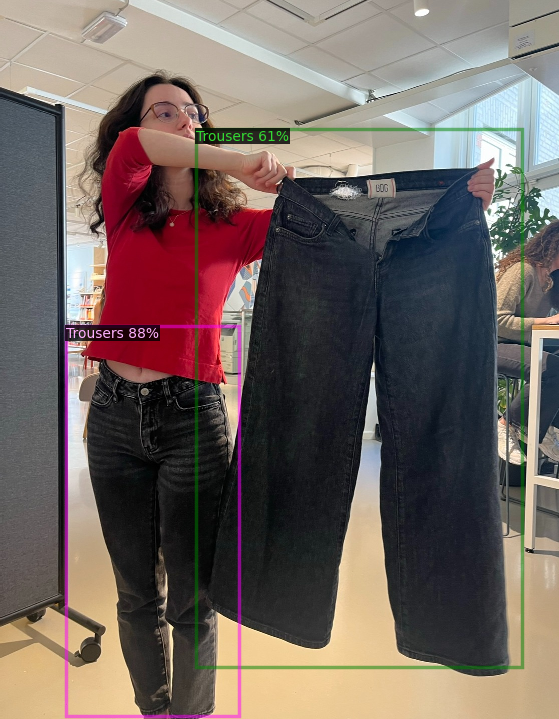

In [ ]:
img = cv2.imread("/content/drive/MyDrive/content/sonorahands.jpeg")
outputs = predictor(img)

pred_classes = outputs["instances"].to("cpu").pred_classes
print (pred_classes)
# Visualize the image with predictions
visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("train_dataset2"), scale=0.5)
v = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

[05/06 22:32:56 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...
tensor([4, 4, 4, 3, 4, 4])


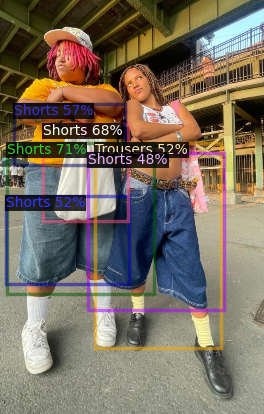

In [ ]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4
predictor = DefaultPredictor(cfg)
img = cv2.imread("/content/drive/MyDrive/content/gema.jpeg")
outputs = predictor(img)

pred_classes = outputs["instances"].to("cpu").pred_classes
print (pred_classes)
# Visualize the image with predictions
visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("train_dataset2"), scale=0.5)
v = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

[05/06 22:35:41 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...
tensor([3, 8])


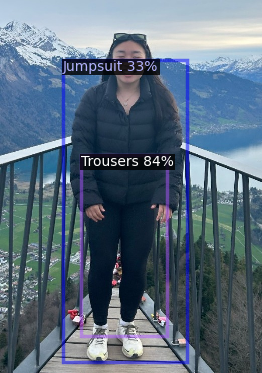

In [ ]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
predictor = DefaultPredictor(cfg)
img = cv2.imread("/content/drive/MyDrive/content/trystan.jpeg")
outputs = predictor(img)

pred_classes = outputs["instances"].to("cpu").pred_classes
print (pred_classes)
# Visualize the image with predictions
visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("train_dataset2"), scale=0.5)
v = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

[05/06 22:46:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...
tensor([3, 3, 8, 2, 4])


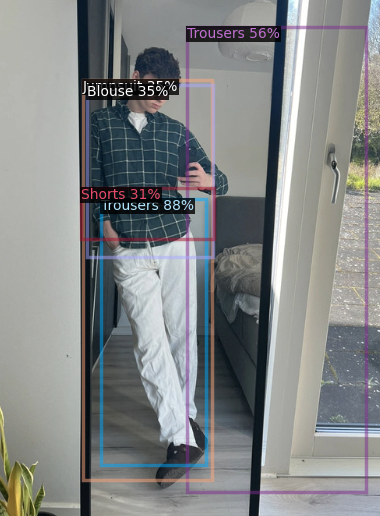

In [ ]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
predictor = DefaultPredictor(cfg)
img = cv2.imread("/content/drive/MyDrive/content/guy.jpeg")
outputs = predictor(img)

pred_classes = outputs["instances"].to("cpu").pred_classes
print (pred_classes)
# Visualize the image with predictions
visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("train_dataset2"), scale=0.5)
v = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

[05/06 22:35:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...
tensor([2])


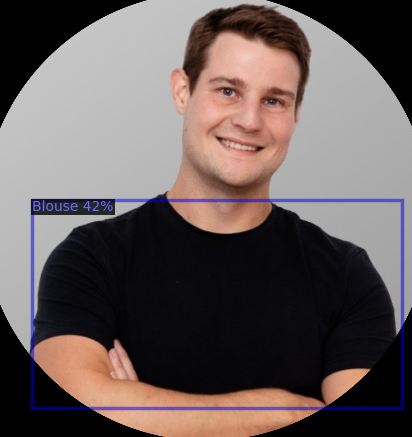

In [ ]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
predictor = DefaultPredictor(cfg)
img = cv2.imread("/content/drive/MyDrive/content/ulrich.jpeg")
outputs = predictor(img)

pred_classes = outputs["instances"].to("cpu").pred_classes
print (pred_classes)
# Visualize the image with predictions
visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("train_dataset2"), scale=0.5)
v = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

[05/06 22:35:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...
tensor([5, 0, 4])


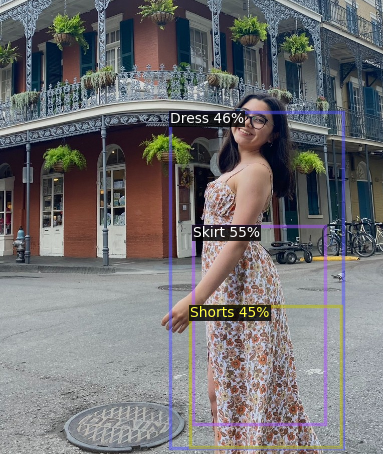

In [ ]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4
predictor = DefaultPredictor(cfg)
img = cv2.imread("/content/drive/MyDrive/content/michelle.jpeg")
outputs = predictor(img)

pred_classes = outputs["instances"].to("cpu").pred_classes
print (pred_classes)
# Visualize the image with predictions
visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("train_dataset2"), scale=0.5)
v = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])